$$ y = -cos(\pi x) + sin(4 \pi x) + \epsilon \quad  \quad 0 \le x \le 10, \epsilon \in N(0, 0.2) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chaospy as cp
from sklearn.linear_model import LarsCV, LassoLarsCV

import time

# Data Generation
np.random.seed(1234)

n = 100
num_rep = 50
X = np.linspace(0,10,n)
X = X.reshape(-1,1)
sigma = 0.5

f_true = lambda x: -np.cos(np.pi * x) + np.sin(4*np.pi * x)

Y = np.empty((n, num_rep))
for i in range(n):
    Y[i, :] = f_true(X[i]) + sigma * np.random.normal(loc=0, scale=sigma, size=num_rep)

# ======== everything above is in a black-box, we only know X, Y ========

np.shape(X), np.shape(Y)

((100, 1), (100, 50))

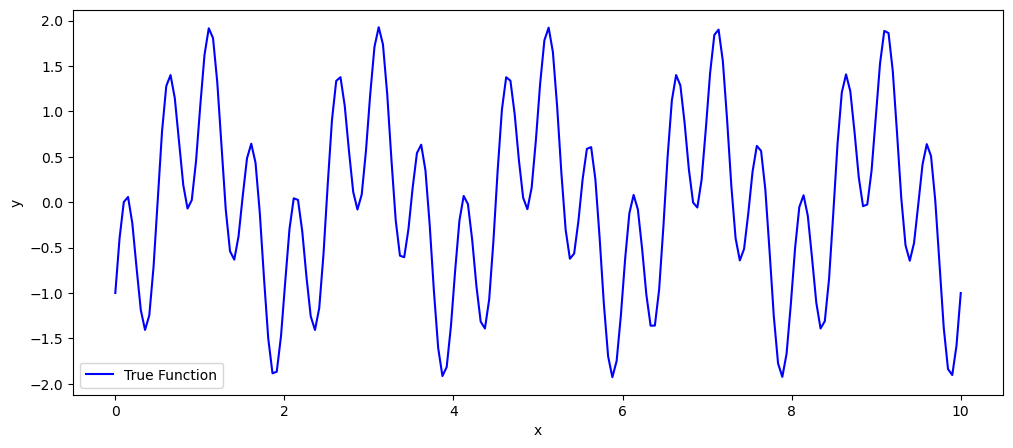

In [2]:
X_true = np.linspace(0, 10, 200).reshape(-1, 1)
Y_true = np.array([f_true(xn) for xn in X_true])

plt.figure(figsize=(12, 5))
plt.plot(X_true, Y_true, label="True Function", color="blue")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [3]:
X_train = X
Y_train = np.mean(Y, axis=1, keepdims=True)
V_train = np.var(Y, axis=1, keepdims=True)

np.shape(X_train), np.shape(Y_train), np.shape(V_train)

((100, 1), (100, 1), (100, 1))

In [4]:
from stochastic_kriging import SimpleStochasticKriging, UK

def rbf_kernel(x1, x2, pars):
    sigma_f, length_scale = pars
    sqdist = np.sum(x1 ** 2, 1).reshape(-1, 1) + np.sum(x2 ** 2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f ** 2 * np.exp(-0.5 / length_scale ** 2 * sqdist)


sk = SimpleStochasticKriging()
sk.kernel = rbf_kernel
sk.train(X_train, Y_train, V_train)


In [5]:
# pck construction

def optimize_pce(pce_expansion, data):
    pce_x, pce_y = data
    lars = LarsCV(fit_intercept=False, max_iter=7)
    pce, coeffs = cp.fit_regression(
        pce_expansion, pce_x, pce_y, model=lars, retall=True)
    pce_expansion_ = pce_expansion[coeffs != 0]
    return pce


In [6]:
pcsk = UK()
distribution = cp.Uniform(0, 10)
expansion = cp.generate_expansion(20, distribution, normed=True)
pcsk.set_trend(expansion)
pcsk.fit_trend(optimize_pce, [X_train.reshape(-1,), Y_train.reshape(-1,)])
pcsk.kernel = rbf_kernel
pcsk.train(X_train, Y_train, V_train)

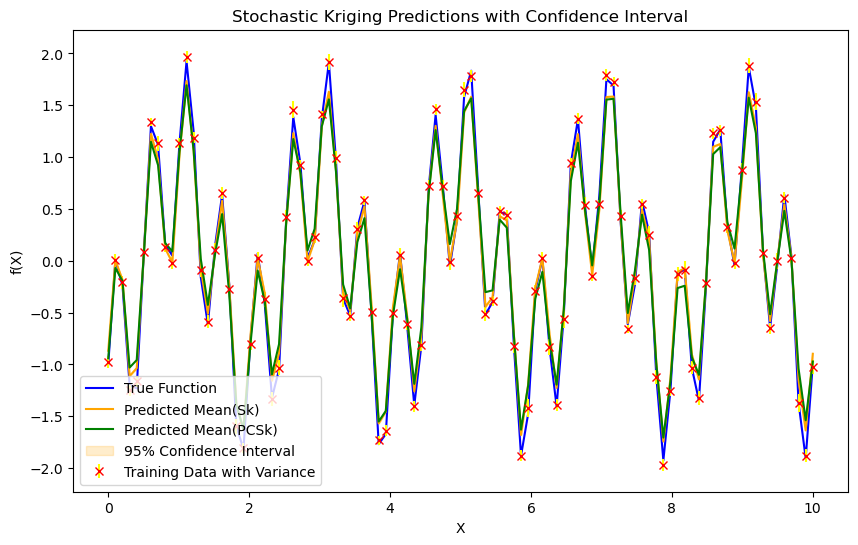

In [7]:
# First try to plot prediction of the mean, mse with the true function

# Generate predictions
X_test_plot = np.linspace(0, 10, 100).reshape(-1, 1)  # Test data
Y_pred_plot, MSE_pred_plot = sk.predict(X_test_plot)  # Predictions from the model(sk)
Y_pred_plot_pcsk, MSE_pred_plot_pcsk = pcsk.predict(X_test_plot)  # Predictions from the model(pcsk)

# True function values
Y_true_plot = f_true(X_test_plot)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_test_plot, Y_true_plot, label='True Function', color='blue')
plt.errorbar(X_train.flatten(), Y_train.flatten(), yerr=V_train.flatten(), fmt='x', color='red', ecolor='yellow', label='Training Data with Variance')
# plt.scatter(X_train, Y_train, color='red', label='Training Data')
plt.plot(X_test_plot, Y_pred_plot, label='Predicted Mean(Sk)', color='orange')
plt.plot(X_test_plot, Y_pred_plot_pcsk, label='Predicted Mean(PCSk)', color='green')

# Confidence interval (e.g., 95%)
lower_bound = Y_pred_plot - 1.96 * np.sqrt(MSE_pred_plot)
upper_bound = Y_pred_plot + 1.96 * np.sqrt(MSE_pred_plot)
plt.fill_between(X_test_plot.flatten(), lower_bound.flatten(), upper_bound.flatten(), color='orange', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('X')
plt.ylabel('f(X)')
plt.title('Stochastic Kriging Predictions with Confidence Interval')
plt.legend()
plt.show()



In [8]:
def calculate_ermse(y_true, y_pred):
    """
    Calculate Empirical Root Mean Squared Error (ERMSE).
    """
    ermse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return ermse

def calculate_nmae(y_true, y_pred):
    """
    Calculate Normalized Maximum Absolute Error (NMAE).
    """
    sigma_ys = np.sqrt(np.mean((y_pred - y_true) ** 2))
    nmae = np.max(np.abs(y_pred - y_true)) / sigma_ys
    return nmae

In [9]:
all_models = dict()
all_models["SK_"+str(50) + "_" + str(20)] = sk
all_models["PCSK_"+str(50) + "_" + str(20)] = pcsk

In [10]:
def perform_analysis(n_validate, metric_function, f_true, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Generate validation data
    # seed the random x's, if None don't seed
    X_validate = np.linspace(0,10,n_validate)
    X_validate = X_validate.reshape(-1,1)
    Y_validate = f_true(X_validate)

    # Dictionary to store predictions and errors
    predictions = {}
    metrics = {}

    # Iterate over each model and evaluate
    for n, model in all_models.items():
        # Predict using the model
        Y_pred, Y_var = model.predict(X_validate)

        # Calculate the error using the provided metric function
        metric = metric_function(Y_validate, Y_pred)

        # Store results
        predictions[n] = Y_pred
        metrics[n] = metric

    return X_validate, predictions, metrics

In [11]:
# 100 trails for replications
# 1e5 points for each validation trial
num_seeds = 100
seeds = []
n_validation = int(1e5)

# Store the results for each seed
all_metrics = {}
all_predictions = {}
all_X_validations = {}

# Example of iterating over 50 seeds
for i in range(num_seeds):
    seed = np.random.randint(0, 100000)  # Generate a random seed
    seeds.append(seed)
    X_validation, predictions, metrics = perform_analysis(n_validation, calculate_ermse, f_true, seed=seed)

    # Store the results
    all_metrics[seed] = metrics
    all_predictions[seed] = predictions
    all_X_validations[seed] = X_validation

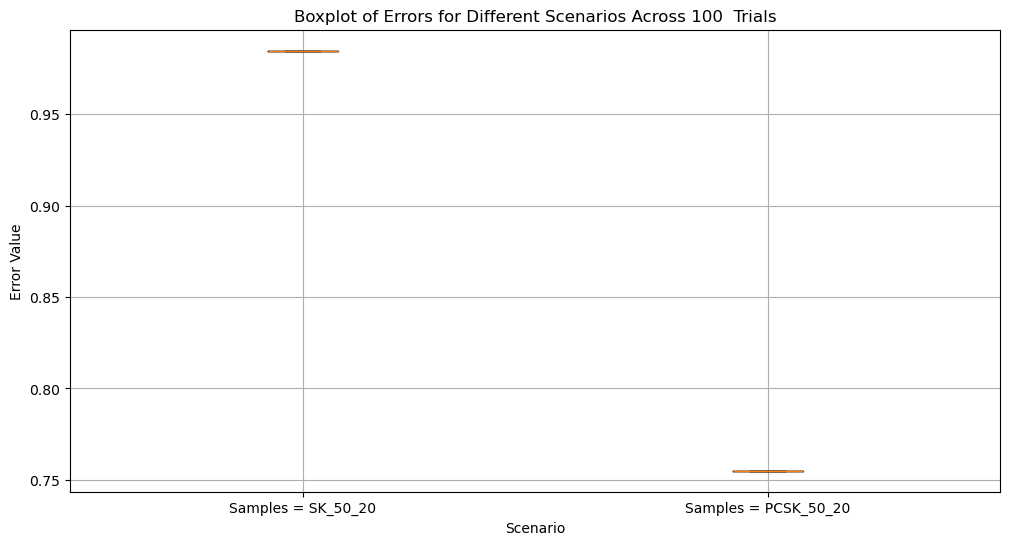

The mean ERMSE is 0.985


In [12]:
# scenarios: keys to all models
scenarios = all_models.keys()

data_runs = [[] for _ in range(len(scenarios))]  # Adjust 'len(scenarios)' to the actual number of scenarios you have

for metrics in all_metrics.values():
    for i, n in enumerate(scenarios):
        data_runs[i].append(metrics[n])

# Create boxplots for these runs
plt.figure(figsize=(12, 6))
plt.boxplot(data_runs, labels=[f"Samples = {n}" for n in scenarios])
plt.title('Boxplot of Errors for Different Scenarios Across ' + str(num_seeds) + '  Trials')
plt.xlabel('Scenario')
plt.ylabel('Error Value')
plt.grid(True)
plt.show()

print(f"The mean ERMSE is {np.mean(data_runs[0]):.3f}")